# Fake News Classifier

## Why is Fake News a problem

Fake news refers to misinformation which is spread through word of mouth and traditional media and more recently through digital forms of communication such as edited videos, memes, unverified advertisements and social media propagated rumours. Fake news spread through social media has become a serious problem, with the potential of it resulting in mob violence, suicides etc as a result of misinformation circulated on social media.

## Importing the required libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from wordcloud import WordCloud,STOPWORDS
from nltk import tokenize
import re
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [3]:
true=pd.read_csv('True.csv')
fake=pd.read_csv('Fake.csv')

In [4]:
print(true.shape)
true.head(5)

(21417, 4)


title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [5]:
print(fake.shape)
fake.head(5)

(23481, 4)


title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

## Data Description

This dataset consists of about 45000 articles consisting of fake as well as real news. Our aim is train our model so that it can correctly predict whether a given piece of news is real or fake.The fake and real news data is given in two separate datasets with the fake dataset containing 23000 entries and the true dataset having 21000 entries.

In [6]:
true['category']='True'
fake['category']='Fake'

In [7]:
data=pd.concat([true,fake])

In [8]:
print(data.shape)
data.sample(frac=1)   # Vieweing some random entries

(44898, 5)


title  \
1184    WATCH: Fox Host Chris Wallace Scolds Fox & Fr...   
20022  INT’L LEADERS CAN’T HIDE DISRESPECT For Obama ...   
2777    WATCH: Actors At SAG Awards BLAST Trump’s Mus...   
11859  Fighting in eastern Ukraine worst since Februa...   
15313  China, U.S. create 'miracle' with $253.4 billi...   
...                                                  ...   
16954  Australia's second largest state edges towards...   
7850   Trump assails House speaker Ryan, McCain as 'd...   
8037   Ohio system of purging inactive voters not leg...   
12410  DWAYNE ‘THE ROCK’ JOHNSON’S Awesome Message To...   
12809  Ex-South Carolina cop gets 20 years in prison ...   

                                                    text       subject  \
1184   Donald Trump s favorite morning propaganda pro...          News   
20022  International leaders aren t making any secret...     left-news   
2777   Everyone is rightfully outraged at the Executi...          News   
11859  KIEV/NOVOLUHANSKE, Ukraine (Reuters) - Fightin...     worldnews   
15313  BEIJING (Reuters) - China and the United State...     worldnews   
...                                                  ...           ...   
16954  SYDNEY (Reuters) - The parliament of Australia...     worldnews   
7850   WASHINGTON (Reuters) - Republican presidential...  politicsNews   
8037   CLEVELAND (Reuters) - Ohio’s practice of resci...  politicsNews   
12410                                                         politics   
12809  CHARLESTON, S.C. (Reuters) - The white former ...     worldnews   

                      date category  
1184         June 11, 2017     Fake  
20022          Sep 5, 2016     Fake  
2777      January 30, 2017     Fake  
11859   December 20, 2017      True  
15313    November 9, 2017      True  
...                    ...      ...  
16954    October 20, 2017      True  
7850     October 11, 2016      True  
8037   September 23, 2016      True  
12410         Nov 13, 2016     Fake  
12809    December 7, 2017      True  

[44898 rows x 5 columns]

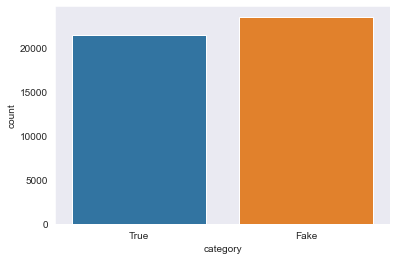

In [9]:
sns.set_style("dark")
sns.countplot(data.category)

* We can see that the dataset is fairly balanced.

In [10]:
data.isnull().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [11]:
data.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

* Most of the entries in the dataset are related to Politics and World News.

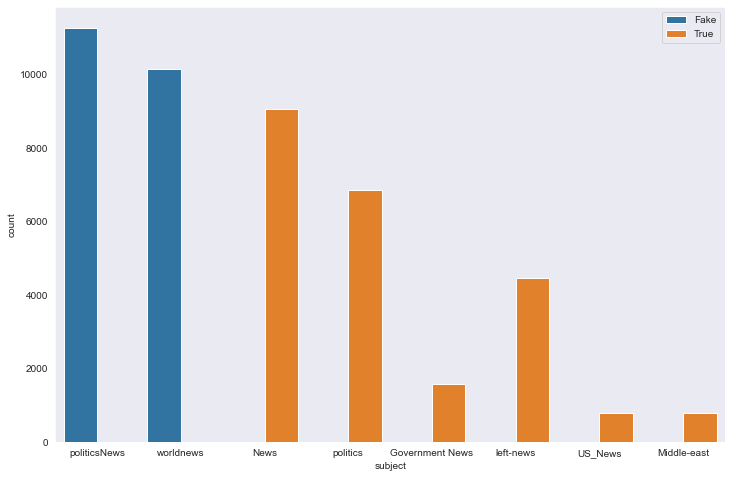

In [12]:
fig= plt.figure(figsize=(12,8))
sns.countplot(x=data['subject'], hue=data['category'])
plt.legend(labels=['Fake','True'])
plt.show()

### Fake News Wordcloud

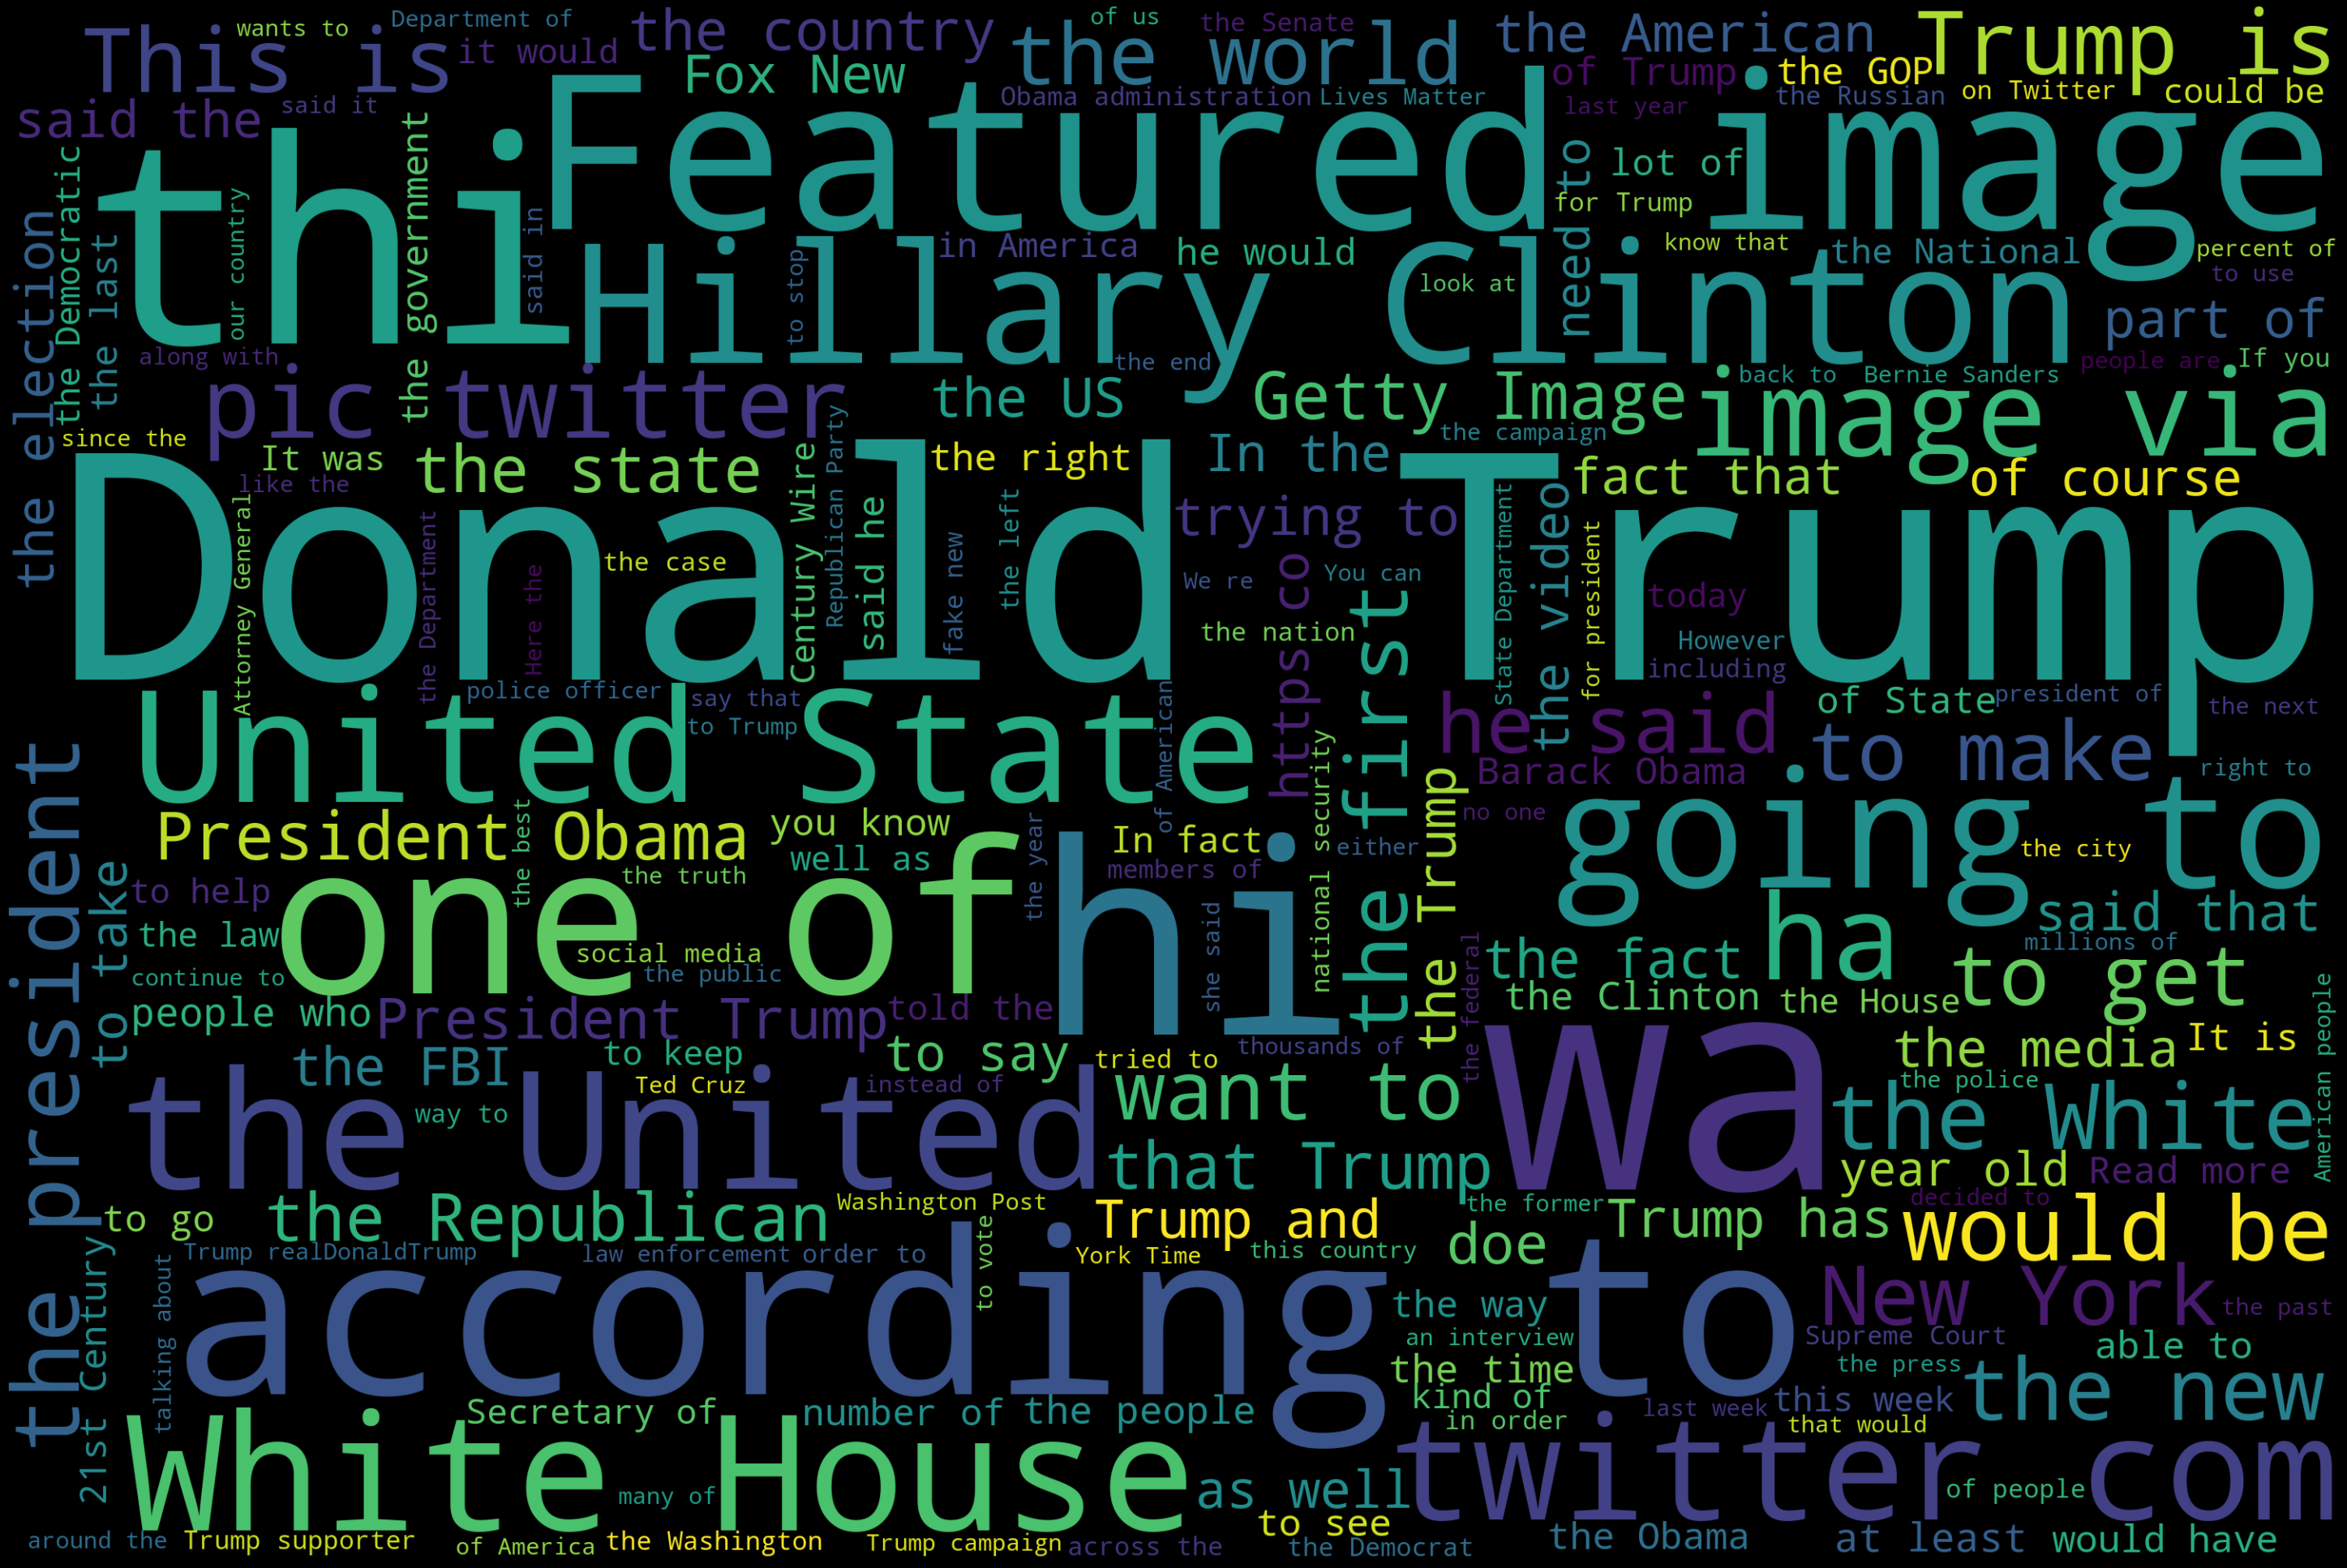

In [38]:
text = ''
for news in fake.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

### Real News WordCloud

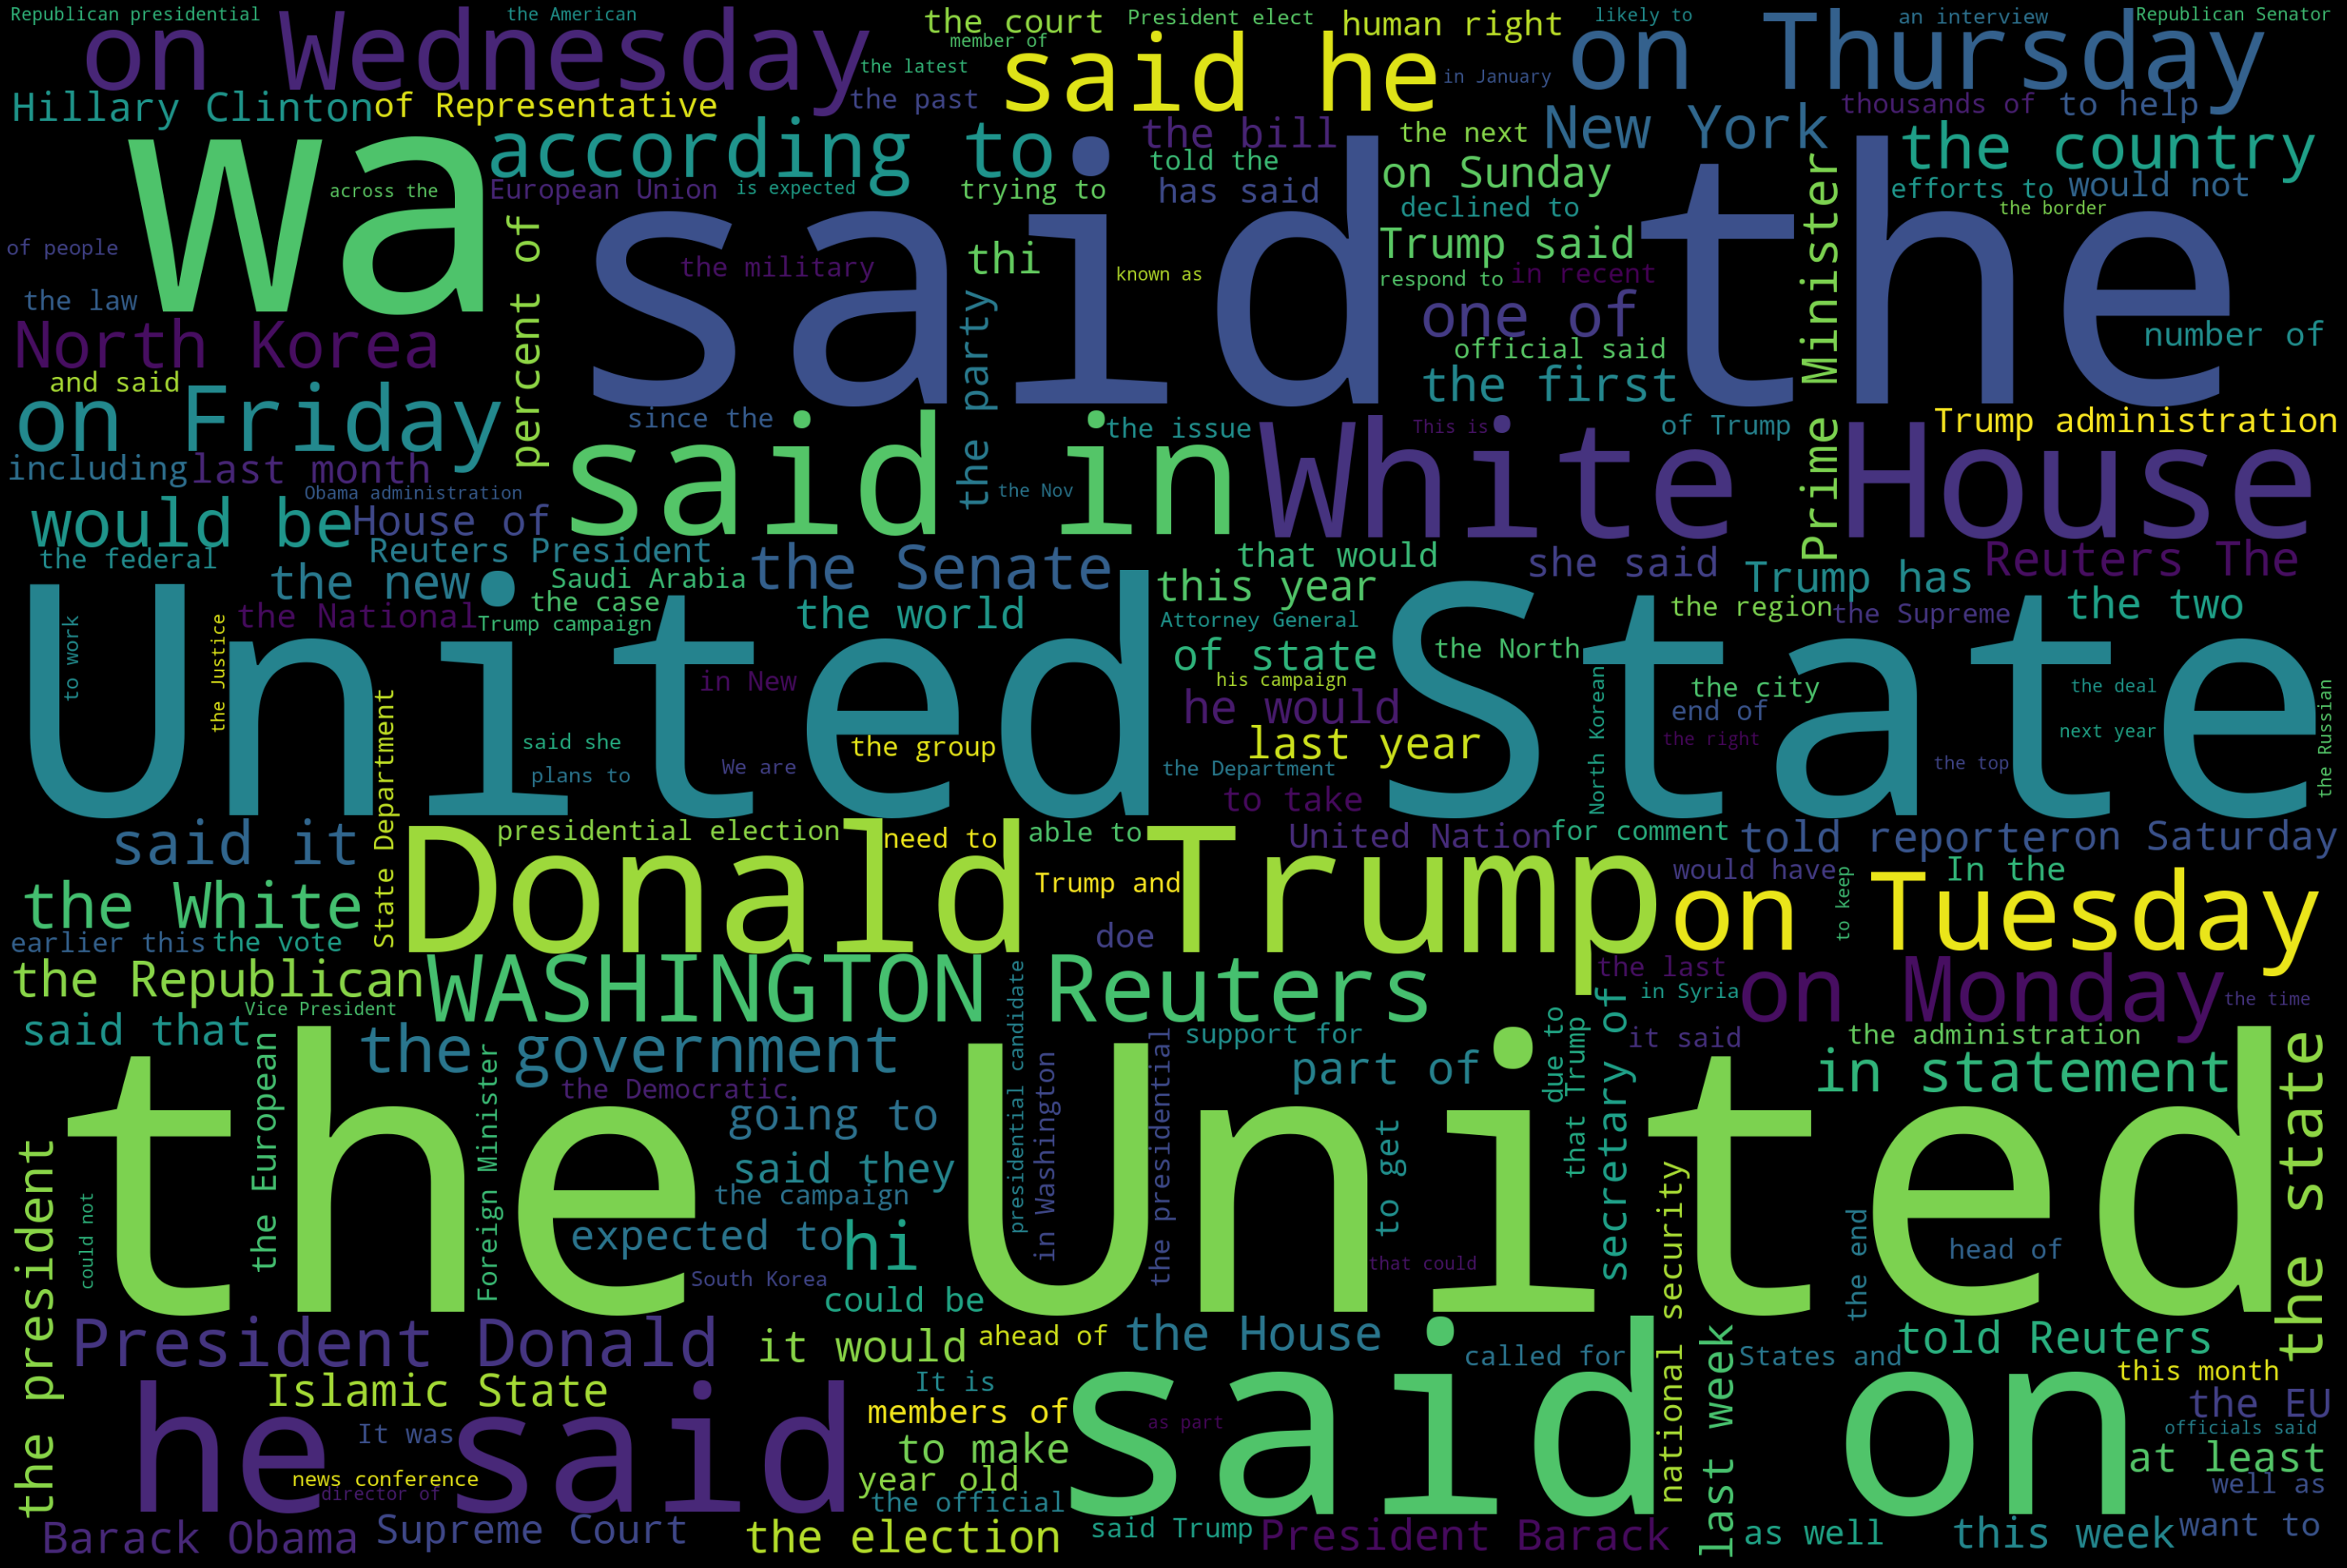

In [39]:
text = ''
for news in true.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

## Preprocessing Text

In [13]:
data['text']=data['title'] + " " + data['text']
data=data.drop(['title','date', 'subject'], axis=1)

* We combined the 'title' and the 'text' columns, then dropped the 'date', 'subject' and 'title' columns.

In [14]:
data.head(10)

text category
0  As U.S. budget fight looms, Republicans flip t...     True
1  U.S. military to accept transgender recruits o...     True
2  Senior U.S. Republican senator: 'Let Mr. Muell...     True
3  FBI Russia probe helped by Australian diplomat...     True
4  Trump wants Postal Service to charge 'much mor...     True
5  White House, Congress prepare for talks on spe...     True
6  Trump says Russia probe will be fair, but time...     True
7  Factbox: Trump on Twitter (Dec 29) - Approval ...     True
8  Trump on Twitter (Dec 28) - Global Warming The...     True
9  Alabama official to certify Senator-elect Jone...     True

* We will now remove the Punctuations, Stop Words and single-character words from the 'text' column.
* The remaining words will be appended to a list.

In [15]:
y=data['category'].values
X = []

stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

for par in data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]  #removes stop words and single char words
        tmp.extend(filtered_words)
    X.append(tmp)

In [16]:
data=pd.DataFrame(list(zip(X,y)), columns=['Text','Category'])

* The 'Text' column now contains a list of words from the original text with the punctuations, stop words and single-character words removed. 
* The string values in the 'Text' column are stored in a list, we will convert these values into one single string. 

In [17]:
def ListToString(sentence):
    str1=" "
    return (str1.join(sentence)) 

data['Text'] = data['Text'].apply(ListToString)

In [18]:
def word_frequency_plot(text, column_text, quantity):
    token_space = tokenize.WhitespaceTokenizer()
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
   
    plt.figure(figsize=(16,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.show()

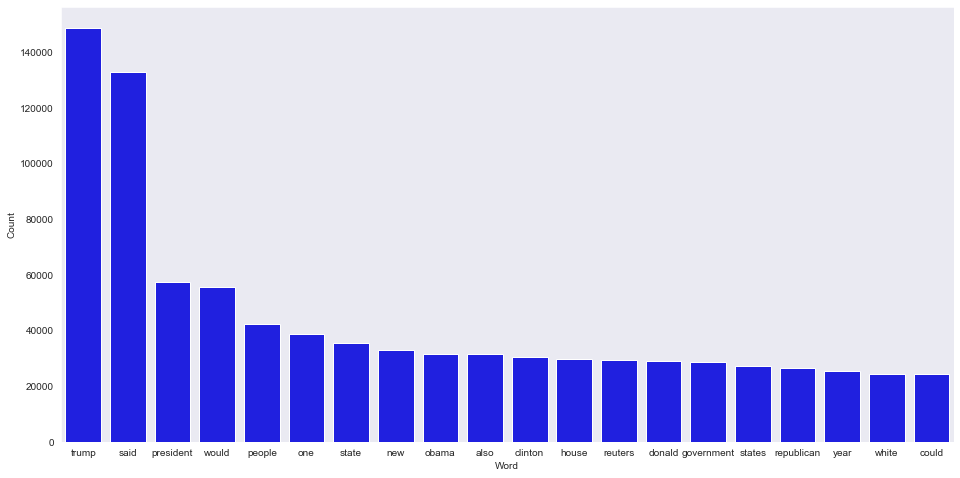

In [19]:
word_frequency_plot(data, "Text", 20)

* The above  plot shows the words with the heighest number of occurences in the datatset after cleaning.

In [20]:
data1=data.copy()
data.head()

Text Category
0  budget fight looms republicans flip fiscal scr...     True
1  military accept transgender recruits monday pe...     True
2  senior republican senator let mr mueller job w...     True
3  fbi russia probe helped australian diplomat ti...     True
4  trump wants postal service charge much amazon ...     True

### TF- IDF Vectorization

In [21]:
y=data['Category']
vect=TfidfVectorizer(max_features=25000, ngram_range=(1,2))
x=vect.fit_transform(data['Text'])

In [22]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size=0.2, random_state=42)

## Building the Model

In [23]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### XGBoost Classifier

Accuracy: 99.57%

Classfication Report:
               precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      4650
        True       0.99      1.00      1.00      4330

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



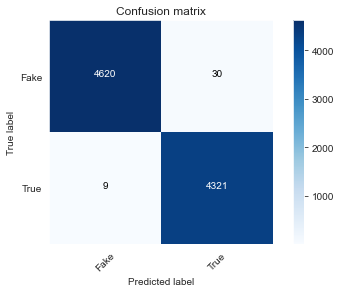

In [24]:
xg_model=XGBClassifier(learning_rate = 0.01, n_estimators = 10, max_depth = 5, random_state=42)
xg_model.fit(x_train,y_train)

prediction=xg_model.predict(x_test)
print("Accuracy: {}%\n".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'True'])
print("Classfication Report:\n", classification_report(y_test,prediction))

### Logistic Regression

Accuracy: 99.22%

Classfication Report:
               precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4650
        True       0.99      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



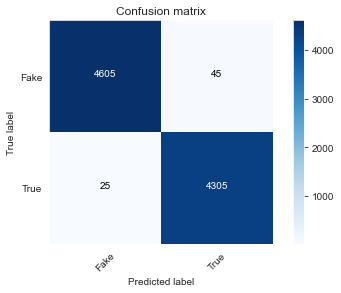

In [25]:
lr_model=LogisticRegression()
lr_model.fit(x_train,y_train)

prediction=lr_model.predict(x_test)
print("Accuracy: {}%\n".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'True'])
print("Classfication Report:\n", classification_report(y_test,prediction))

### Random Forest Classifier

Accuracy: 99.71%

Classfication Report:
               precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4650
        True       1.00      1.00      1.00      4330

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



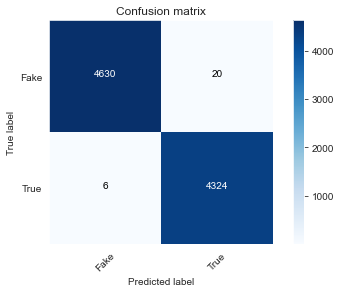

In [26]:
rf_model=RandomForestClassifier()
rf_model.fit(x_train,y_train)

prediction=rf_model.predict(x_test)
print("Accuracy: {}%\n".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'True'])
print("Classfication Report:\n", classification_report(y_test,prediction))

* The accuracy and F1 scores we get with Random Forest Classifier are excellent, so we do not need to perform any hyperparameter tuning.

### Multinomial Naive Bayes

In [27]:
nb=MultinomialNB()

In [28]:
previous_score=0
for alpha in np.arange(0,1,0.1):
    classifier=MultinomialNB(alpha=alpha)
    classifier.fit(x_train,y_train)
    y_pred=classifier.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    if score>previous_score:
        nb=classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

Alpha: 0.0, Score : 0.974053452115813
Alpha: 0.1, Score : 0.9622494432071269
Alpha: 0.2, Score : 0.9616926503340757
Alpha: 0.30000000000000004, Score : 0.9604677060133631
Alpha: 0.4, Score : 0.960022271714922
Alpha: 0.5, Score : 0.9593541202672605
Alpha: 0.6000000000000001, Score : 0.9589086859688196
Alpha: 0.7000000000000001, Score : 0.9583518930957684
Alpha: 0.8, Score : 0.9575723830734967
Alpha: 0.9, Score : 0.9574610244988864


Accuracy: 95.75%

Classfication Report:
               precision    recall  f1-score   support

        Fake       0.96      0.96      0.96      4650
        True       0.96      0.96      0.96      4330

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



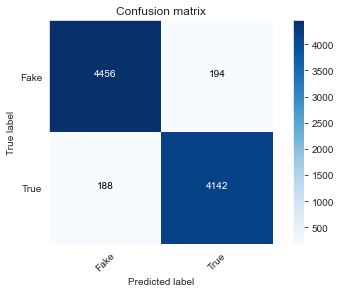

In [29]:
prediction=nb.predict(x_test)
print("Accuracy: {}%\n".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'True'])
print("Classfication Report:\n", classification_report(y_test,prediction))

## Conclusion

In this project, we utilised the "Fake and real news dataset" from Kaggle to develop a classifier capable of differentiating between Fake and Real news. We used 4 different classifiers in the project, namely XGBoost, Random Forest, Logistic Regression and Multinomial Naive Bayes. 

The best performace metrics were achieved by the ***Random Forest Classifier***, as given below:
* Accuracy: ***99.7%***
* F1-Score- ***1.00***
